Accident-Severity-Prediction

This cell imports necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Cell 1 - Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.linear_model import LogisticRegression
import warnings
import os
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')

This cell defines a function to load data in chunks to avoid memory issues. It then loads the accident data and displays initial information about the data.

In [2]:
# Cell 2 - Load and Examine Raw Data
# Load data
def load_data_in_chunks(filepath, chunk_size=10000):
    relevant_columns = [
        'Severity', 'Distance(mi)', 'Temperature(F)', 'Wind_Speed(mph)',
        'Visibility(mi)', 'Precipitation(in)', 'Humidity(%)', 'Pressure(in)',
        'Weather_Condition', 'Crossing', 'Junction', 'Traffic_Signal'
    ]
    
    chunks = []
    total_size = 0
    
    for chunk in pd.read_csv(filepath, chunksize=chunk_size, usecols=relevant_columns):
        total_size += chunk.memory_usage(deep=True).sum() / 1024**2
        print(f"Loaded chunk: {total_size:.2f} MB")
        chunks.append(chunk)
        
        if len(chunks) * chunk_size >= 100000:  # Limit samples for memory
            break
    
    return pd.concat(chunks, ignore_index=True)

# Load the data
df = load_data_in_chunks("US_Accidents_March23.csv")

# Display initial data info
print("\n=== Initial Data Overview ===")
print(df.info())
print("\n=== Missing Values ===")
print(df.isnull().sum())
print("\n=== Sample Data ===")
print(df.head())

Loaded chunk: 1.25 MB
Loaded chunk: 2.51 MB
Loaded chunk: 3.76 MB
Loaded chunk: 5.02 MB
Loaded chunk: 6.26 MB
Loaded chunk: 7.51 MB
Loaded chunk: 8.76 MB
Loaded chunk: 10.00 MB
Loaded chunk: 11.25 MB
Loaded chunk: 12.49 MB

=== Initial Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Severity           100000 non-null  int64  
 1   Distance(mi)       100000 non-null  float64
 2   Temperature(F)     98409 non-null   float64
 3   Humidity(%)        98144 non-null   float64
 4   Pressure(in)       98708 non-null   float64
 5   Visibility(mi)     98154 non-null   float64
 6   Wind_Speed(mph)    76180 non-null   float64
 7   Precipitation(in)  7368 non-null    float64
 8   Weather_Condition  98396 non-null   object 
 9   Crossing           100000 non-null  bool   
 10  Junction           100000 non-null  bool   

This cell defines a function to clean and process the data. This includes handling missing values, converting categorical variables, handling outliers, converting data types for memory efficiency, creating new features, and selecting the most important features.

=== Data Cleaning and Feature Engineering Steps ===

Step 1: Handling missing values
Rows removed due to missing values: 93602

Step 2: Converting categorical variables

Step 3: Handling outliers

Step 4: Optimizing data types

=== Final Data Shape ===
Final dataset shape: (6398, 12)

Step 1-4: Performing basic cleaning...

Step 5: Creating weather severity score

Step 6: Creating interaction features

Step 7: Generating binary indicators

Step 8: Selecting features using mutual information

=== Final Enhanced Dataset Shape ===
Final dataset shape: (6398, 19)


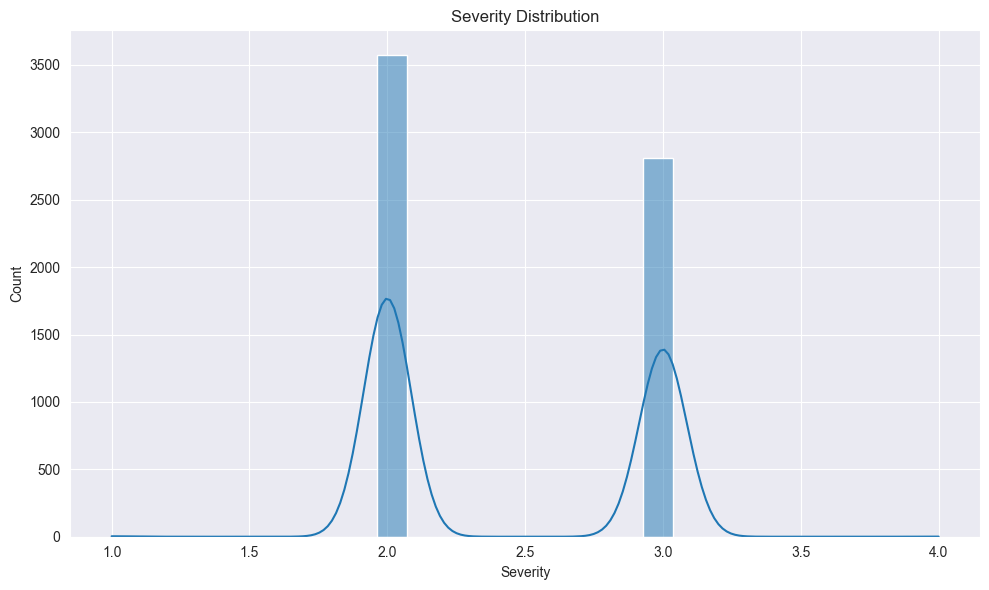

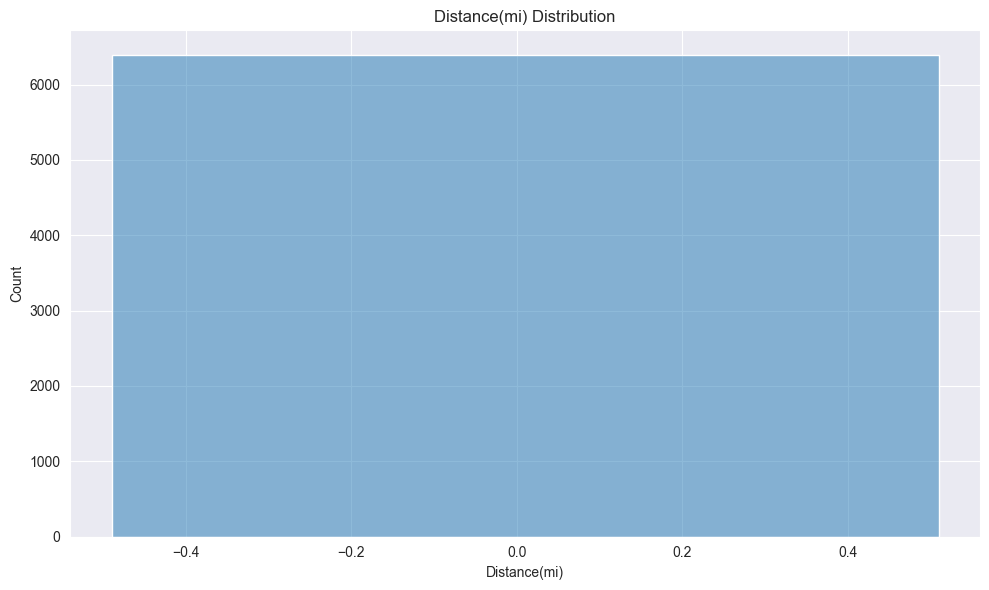

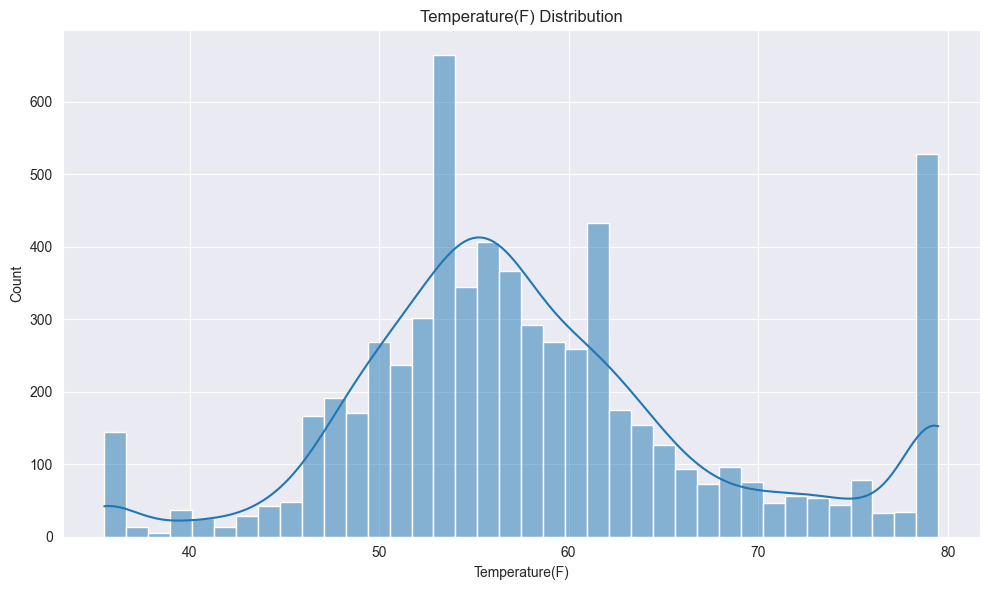

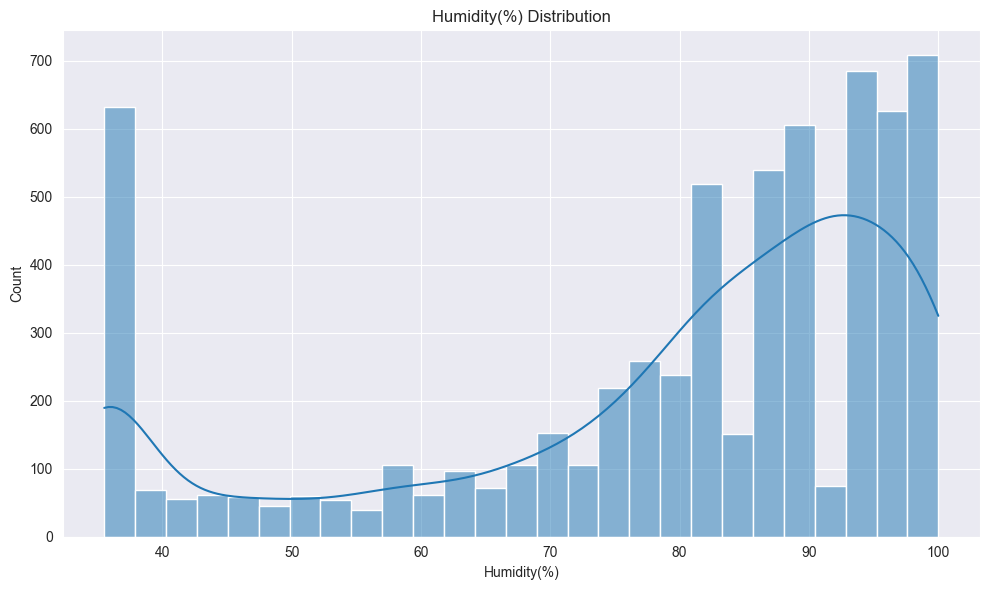

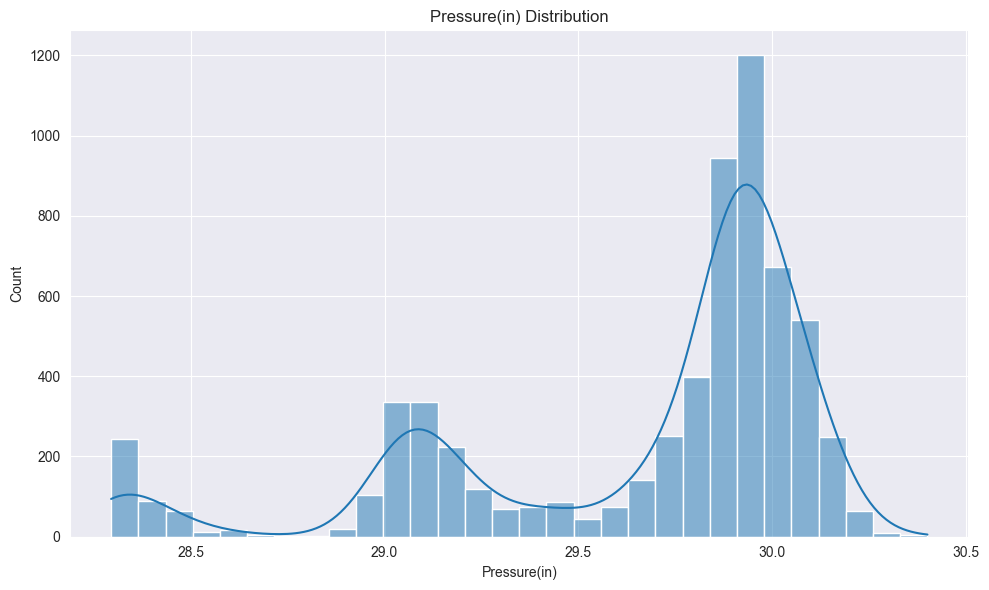

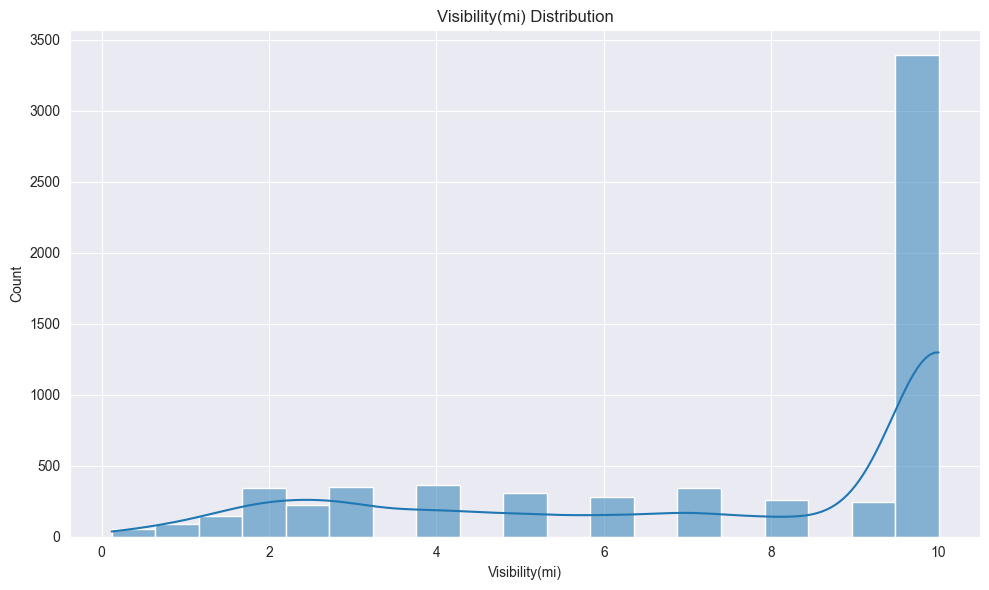

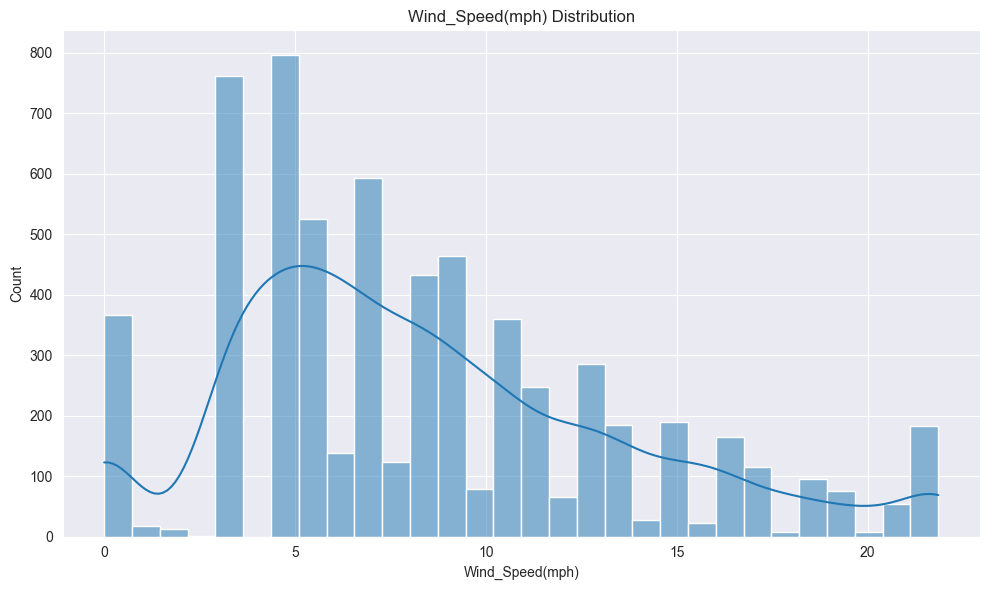

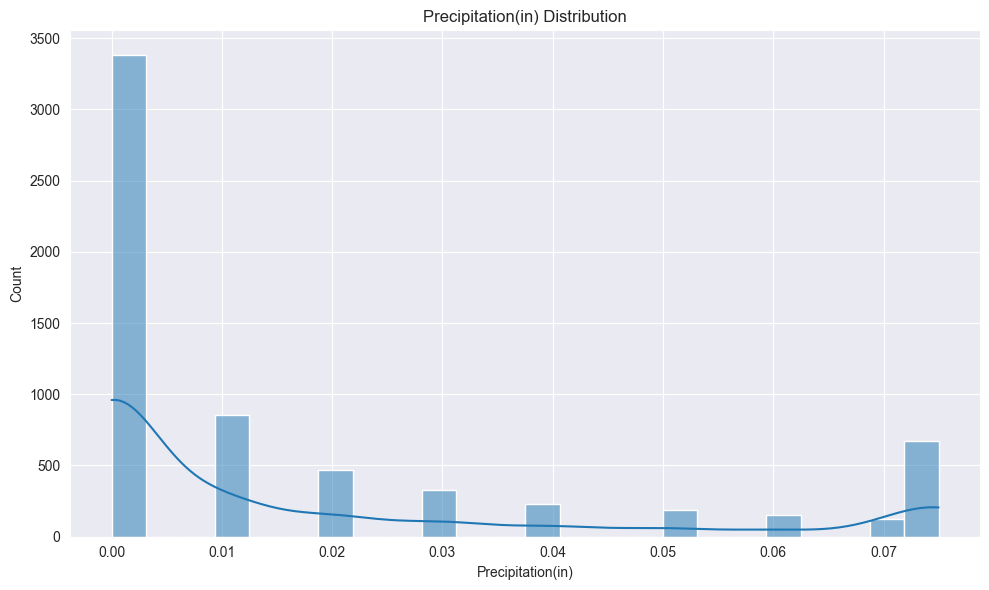

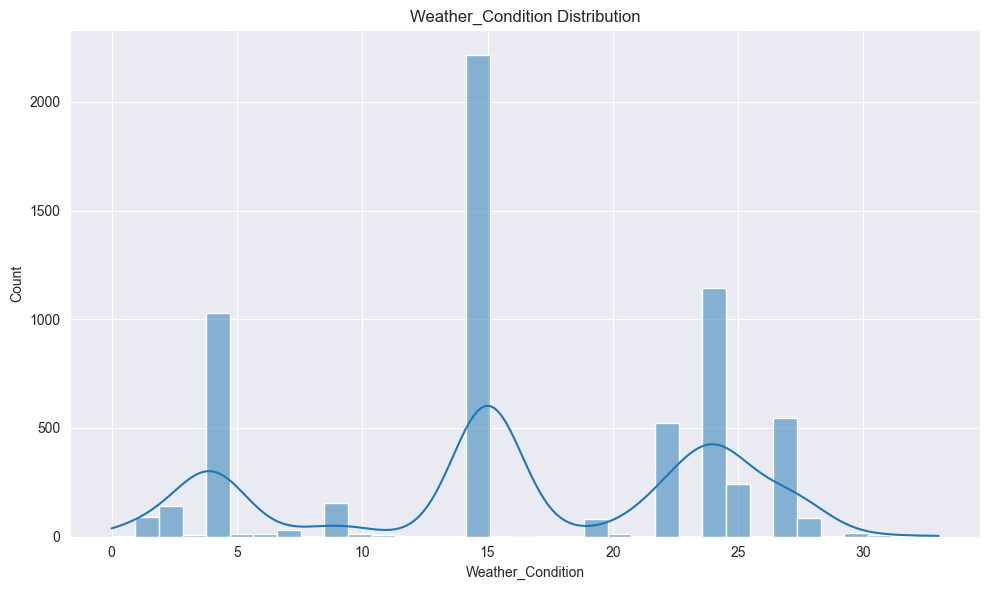

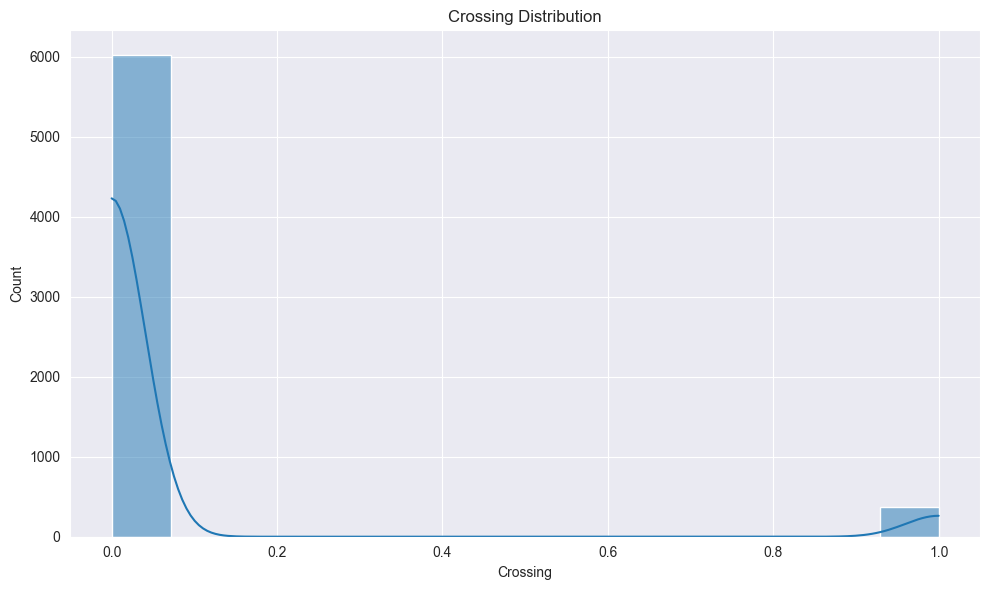

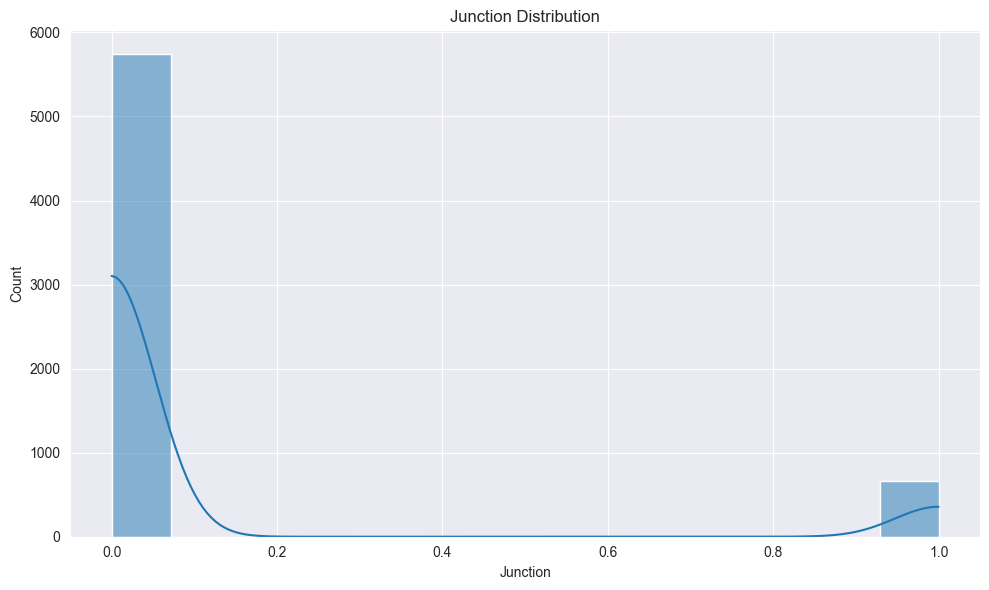

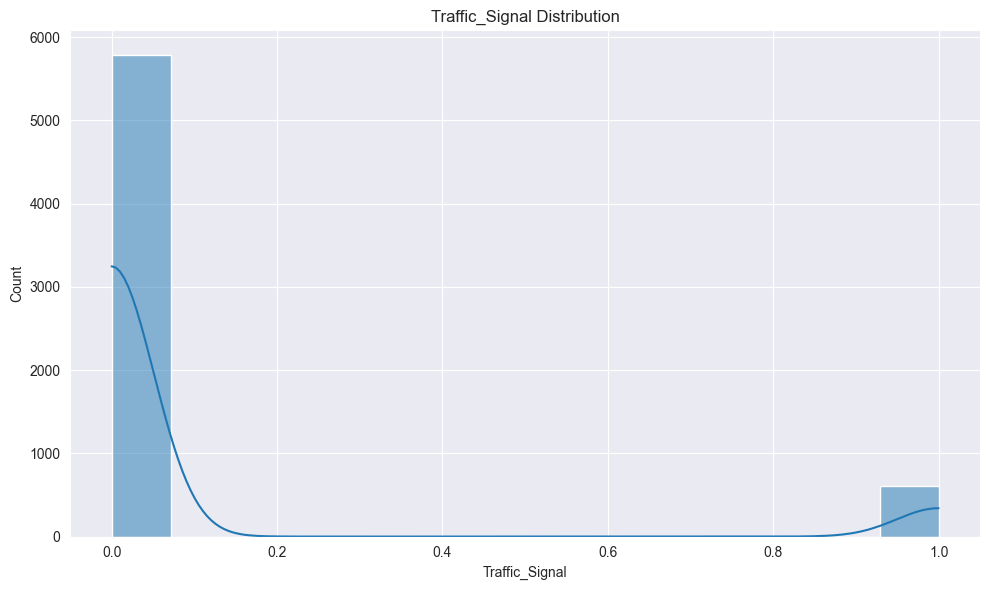

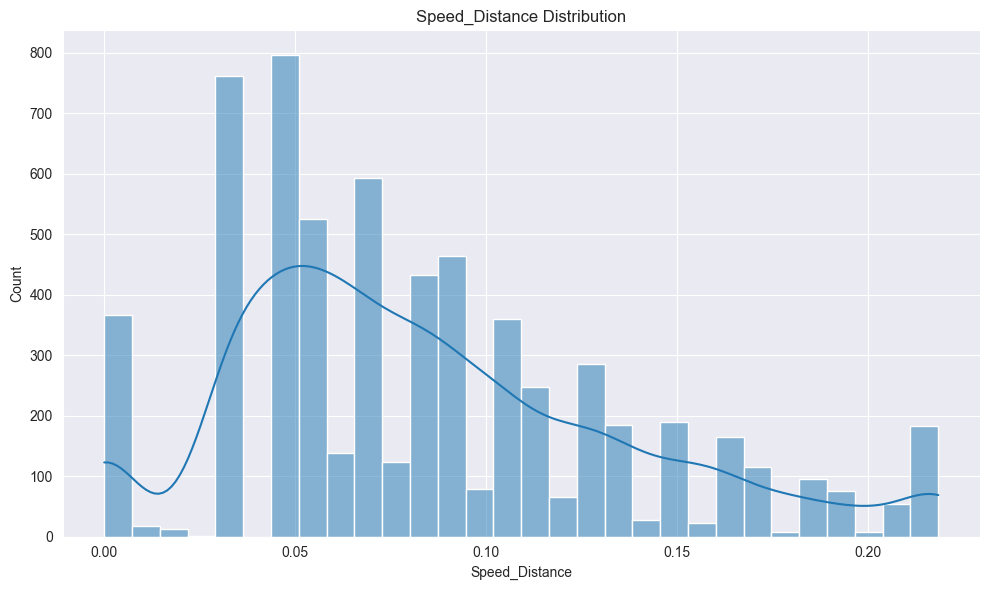

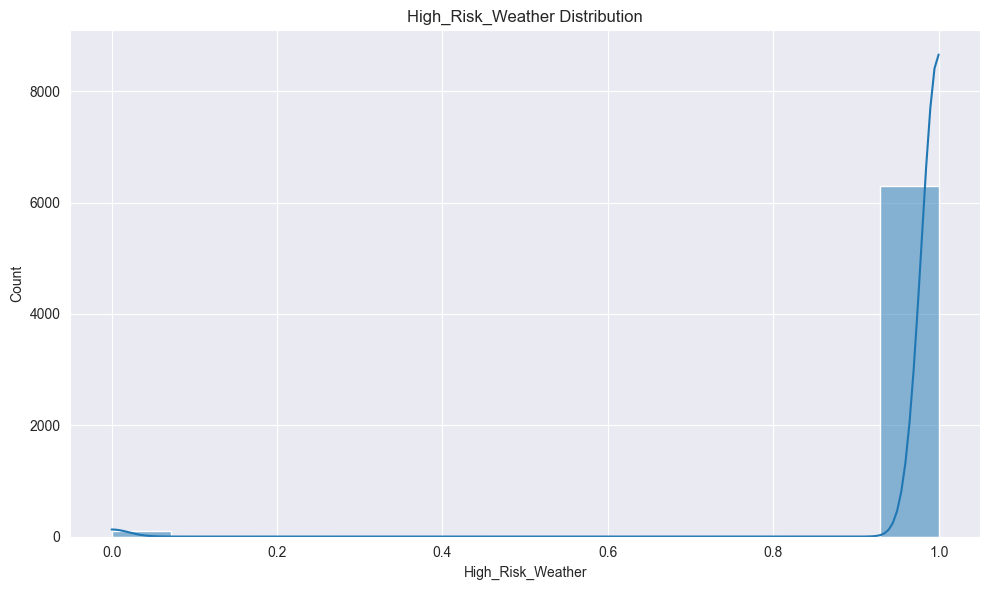

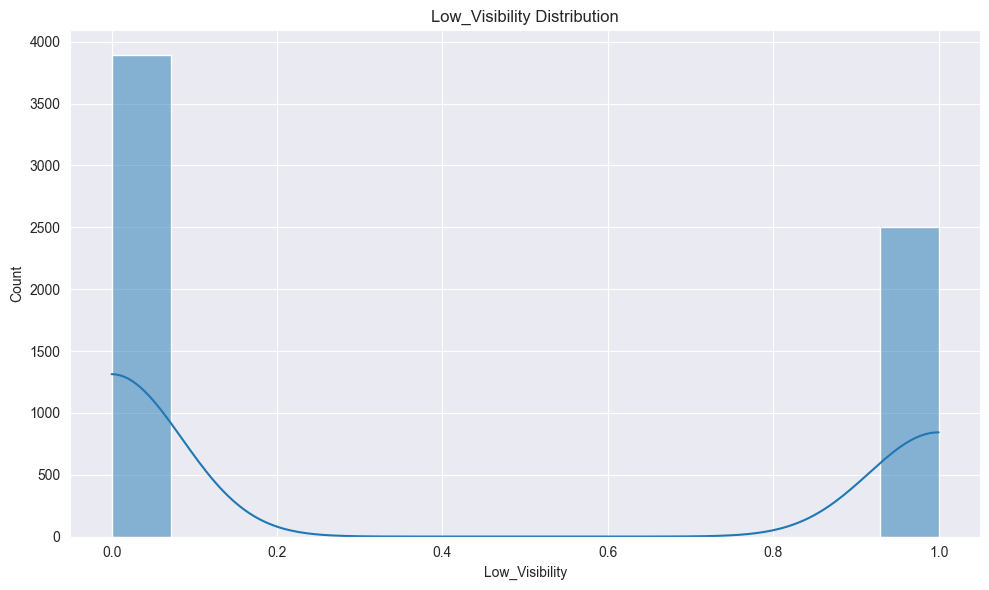

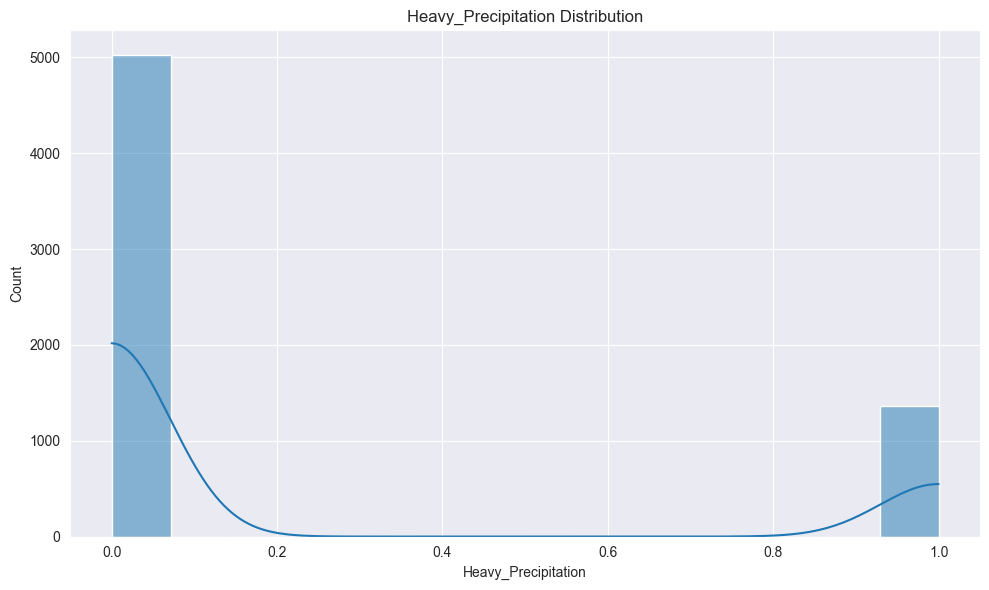

In [3]:
# Cell 3 - Enhanced Data Cleaning and Feature Engineering
# Define the function for data cleaning and feature engineering
def clean_and_process_data(df):
    print("=== Data Cleaning and Feature Engineering Steps ===")
    
    # 1. Handle missing values
    print("\nStep 1: Handling missing values")
    initial_rows = len(df)
    df = df.dropna()
    print(f"Rows removed due to missing values: {initial_rows - len(df)}")
    
    # 2. Convert categorical variables
    print("\nStep 2: Converting categorical variables")
    categorical_columns = ['Weather_Condition', 'Crossing', 'Junction', 'Traffic_Signal']
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # 3. Handle outliers using IQR method
    print("\nStep 3: Handling outliers")
    numeric_columns = ['Distance(mi)', 'Temperature(F)', 'Wind_Speed(mph)', 
                      'Visibility(mi)', 'Precipitation(in)', 'Humidity(%)', 'Pressure(in)']
    
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower_bound, upper_bound)
    
    # 4. Convert datatypes for memory optimization
    print("\nStep 4: Optimizing data types")
    df = df.astype({
        'Distance(mi)': 'float32',
        'Temperature(F)': 'float32',
        'Wind_Speed(mph)': 'float32',
        'Visibility(mi)': 'float32',
        'Precipitation(in)': 'float32',
        'Humidity(%)': 'float32',
        'Pressure(in)': 'float32',
        'Severity': 'int32'
    })
    
    print("\n=== Final Data Shape ===")
    print(f"Final dataset shape: {df.shape}")
    
    # Previous cleaning steps remain the same
    print("\nStep 1-4: Performing basic cleaning...")
    
    # 5. Create weather severity scoring
    print("\nStep 5: Creating weather severity score")
    weather_severity = {
        'Clear': 0, 'Cloudy': 1, 'Rain': 2, 'Snow': 3, 
        'Thunderstorm': 4, 'Fog': 3, 'Hail': 4
    }
    df['Weather_Severity'] = df['Weather_Condition'].map(lambda x: 2)  # Default score
    
    # 6. Generate interaction features
    print("\nStep 6: Creating interaction features")
    df['Weather_Visibility'] = df['Weather_Condition'] * df['Visibility(mi)']
    df['Speed_Distance'] = df['Wind_Speed(mph)'] * df['Distance(mi)']
    df['Weather_Pressure'] = df['Weather_Condition'] * df['Pressure(in)']
    
    # 7. Create binary indicators
    print("\nStep 7: Generating binary indicators")
    df['High_Risk_Weather'] = (df['Weather_Condition'] >= 2).astype(int)
    df['Low_Visibility'] = (df['Visibility(mi)'] < df['Visibility(mi)'].mean()).astype(int)
    df['Heavy_Precipitation'] = (df['Precipitation(in)'] > df['Precipitation(in)'].quantile(0.75)).astype(int)
    
    # 8. Select best features using mutual information
    print("\nStep 8: Selecting features using mutual information")
    numeric_features = df.select_dtypes(include=['float32', 'int32']).columns
    numeric_features = numeric_features.drop('Severity')
    mi_scores = mutual_info_classif(df[numeric_features], df['Severity'])
    mi_series = pd.Series(mi_scores, index=numeric_features).sort_values(ascending=False)
    selected_features = mi_series[mi_series > mi_series.mean()].index.tolist()
    
    print("\n=== Final Enhanced Dataset Shape ===")
    print(f"Final dataset shape: {df.shape}")
    
    return df

# Clean and process the data
cleaned_df = clean_and_process_data(df)

# Create the directory if it doesn't exist
os.makedirs('Visualizations', exist_ok=True)

# Visualize distributions after cleaning - saving each plot as a separate image
numeric_columns = cleaned_df.select_dtypes(include=['float32', 'int32']).columns

for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(cleaned_df[column], kde=True)
    plt.title(f'{column} Distribution')
    plt.tight_layout()
    # Save each plot as a separate file in the Visualizations folder
    plt.savefig(f'Visualizations/{column}_distribution.png')
    plt.show()  


This cell prepares the data for training and evaluation. It splits the data into training, validation, and test sets. It also scales the features and creates balanced datasets using SMOTE and RandomUnderSampler.

In [4]:
# Cell 4 - Enhanced Data Split and Preprocessing with Balancing
# Prepare features and target
X = cleaned_df.drop('Severity', axis=1)
y = cleaned_df['Severity']

# Calculate class weights
class_weights = dict(zip(
    np.unique(y),
    1 / np.bincount(y) * len(y) / 2
))

# First split: separate test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Second split: separate train (75%) and validation (15%)
test_size_adjusted = 0.15 / 0.90
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=test_size_adjusted, random_state=42, stratify=y_temp
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create balanced datasets using SMOTE and RandomUnderSampler
smote = SMOTE(k_neighbors=1, random_state=42)
rus = RandomUnderSampler(random_state=42)
balancing_pipeline = imbPipeline([
    ('smote', smote),
    ('undersampling', rus)
])

X_train_balanced, y_train_balanced = balancing_pipeline.fit_resample(X_train_scaled, y_train)

print("=== Enhanced Data Split Sizes ===")
print(f"Original training set: {X_train_scaled.shape}")
print(f"Balanced training set: {X_train_balanced.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")


=== Enhanced Data Split Sizes ===
Original training set: (4798, 18)
Balanced training set: (10728, 18)
Validation set: (960, 18)
Test set: (640, 18)


This cell calculates class weights and creates an ensemble of three machine learning models: Random Forest, Gradient Boosting, and Logistic Regression. It then performs cross-validation to evaluate the models and trains them on the balanced training set. Finally, it generates predictions on the validation and test sets, prints classification reports, and visualizes the results.

In [ ]:
# Cell 5 

# Calculate class weights
unique_classes = np.unique(y)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=y
)
class_weights = dict(zip(unique_classes, class_weights))

# Check Class Weights
print("Class Weights:", class_weights)

# Create ensemble of models
models = {
    'rf': RandomForestClassifier(
        n_estimators=50, max_depth=10, 
        min_samples_split=10, class_weight=class_weights,
        random_state=42
    ),
    'gb': GradientBoostingClassifier(
        n_estimators=50, max_depth=5,
        random_state=42
    ),
    'lr': LogisticRegression(
        max_iter=1000, class_weight=class_weights,
        random_state=42
    )
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate models
print("=== Training and Evaluating Models ===")
predictions = {}
cv_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Cross-validation scores
    cv_scores[name] = cross_val_score(
        model, X_train_balanced, y_train_balanced, 
        cv=cv, scoring='accuracy'
    )
    
    # Train on full training set
    model.fit(X_train_balanced, y_train_balanced)
    
    # Generate predictions
    predictions[name] = {
        'val': model.predict(X_val_scaled),
        'test': model.predict(X_test_scaled)
    }

# Ensemble predictions (majority voting)
val_ensemble = np.array([predictions[name]['val'] for name in models.keys()])
test_ensemble = np.array([predictions[name]['test'] for name in models.keys()])

y_val_pred = np.apply_along_axis(
    lambda x: np.bincount(x).argmax(),
    axis=0,
    arr=val_ensemble
)
y_test_pred = np.apply_along_axis(
    lambda x: np.bincount(x).argmax(),
    axis=0,
    arr=test_ensemble
)

# Print results
print("\n=== Cross-Validation Results ===")
for name, scores in cv_scores.items():
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

print("\n=== Validation Results ===")
print(classification_report(y_val, y_val_pred))

print("\n=== Test Results ===")
print(classification_report(y_test, y_test_pred))

# Enhanced visualization of results
fig = plt.figure(figsize=(20, 10))

# Confusion matrices
ax1 = plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', ax=ax1)
ax1.set_title('Validation Confusion Matrix')
plt.tight_layout()
# Save validation confusion matrix
plt.savefig('Visualizations/validation_confusion_matrix.png')

ax2 = plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', ax=ax2)
ax2.set_title('Test Confusion Matrix')
plt.tight_layout()
# Save test confusion matrix
plt.savefig('Visualizations/test_confusion_matrix.png')

# Cross-validation scores
ax3 = plt.subplot(2, 2, 3)
cv_data = pd.DataFrame(cv_scores).melt()
sns.boxplot(x='variable', y='value', data=cv_data, ax=ax3)
ax3.set_title('Cross-Validation Scores by Model')
ax3.set_xlabel('Model')
ax3.set_ylabel('Accuracy')
plt.tight_layout()
# Save cross-validation scores
plt.savefig('Visualizations/cross_validation_scores.png')

plt.show()  # Display the figure inline with all charts
plt.close()  # Close the figure to avoid displaying it inline


Class Weights: {1: 228.5, 2: 0.4471624266144814, 3: 0.5688122332859175, 4: 799.75}
=== Training and Evaluating Models ===

Training rf...

Training gb...


This cell analyzes the feature importance from the Random Forest model to identify the most important features for predicting accident severity. It also provides recommendations for further research and improvements.

In [ ]:
# Cell 6 - Enhanced Feature Importance and Recommendations

# Aggregate feature importance from Random Forest model
rf_model = models['rf']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Create the directory if it doesn't exist
os.makedirs('Visualizations', exist_ok=True)

# Create enhanced visualization and save it separately
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feature_importance.head(15),
    x='importance',
    y='feature'
)
plt.title('Top 15 Features by Importance')
plt.tight_layout()
# Save the plot as a separate file in the Visualizations folder
plt.savefig('Visualizations/top_15_features_importance.png')
plt.show()

print("\n=== Research Recommendations ===")

# Recommendation 1
print("1. Incorporate More Data Sources:")
print("   - Explore incorporating additional datasets such as real-time traffic data, road construction schedules, and accident reports from different regions.")
print("   - Integration of external APIs like weather or location data for real-time predictions.")

# Recommendation 2
print("2. Hyperparameter Optimization:")
print("   - Employ advanced optimization techniques like Bayesian Optimization or Hyperband for tuning model hyperparameters.")
print("   - Use grid search or random search to identify optimal hyperparameters for both individual models and ensemble configurations.")

# Recommendation 3
print("3. Exploration of Deep Learning Models:")
print("   - Experiment with neural network architectures like CNNs or RNNs to capture spatial and temporal patterns more effectively.")
print("   - Utilize pre-trained models or transfer learning for feature extraction and model efficiency.")

# Recommendation 4
print("4. Enhanced Feature Engineering:")
print("   - Investigate additional temporal features like holidays, peak hours, or special events.")
print("   - Explore polynomial features or interaction terms to capture complex relationships.")

# Recommendation 5
print("5. Real-Time Prediction Systems:")
print("   - Build APIs or lightweight services for real-time accident severity prediction using frameworks like Flask or FastAPI.")
print("   - Optimize latency and ensure scalability for live deployment environments.")

# Recommendation 6
print("6. Improvements in Visualization and Reporting:")
print("   - Develop interactive dashboards using tools like Dash or Power BI to provide actionable insights to stakeholders.")
print("   - Enhance interpretability by integrating tools like SHAP or LIME for better explanation of model decisions.")

# Recommendation 7
print("7. Robust Model Evaluation:")
print("   - Use advanced cross-validation techniques like stratified K-fold to ensure balanced evaluation.")
print("   - Experiment with metrics like ROC-AUC or PR-AUC to provide a holistic view of model performance.")

# Final Note
print("These recommendations aim to enhance the model's predictive capabilities, ensure robust evaluation, and provide practical tools for stakeholders.")

